In [15]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from z3 import *
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import itertools

In [16]:
fix = np.array([[0, 8, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 4, 0, 0, 0, 0, 7],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 4, 0, 9, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 5, 0, 0, 0, 0, 0, 0]])

nodes = np.array([[0, 0, 0, 0, 0, 1, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 2, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 2, 0],
                  [0, 0, 0, 0, 0, 3, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 3, 0, 0],
                  [0, 0, 0, 4, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 5, 0, 0],
                  [4, 0, 5, 0, 0, 0, 0, 0, 0]])

In [45]:
def sol_print(solution,edge_result,node):
    colours = ['w','r','g','b','cyan','magenta']
    x= np.ones((3,3))
    groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array(solution.astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(node,annot=x,cbar=False,cmap=ListedColormap(colours),fmt="",linewidths=1,
                     linecolor='k',annot_kws={"size":14})
    for i,j in itertools.product([n for n in[0,3,6]],repeat=2):
        ax.add_patch(Rectangle((i,j),3,3,fill=False,edgecolor='k',lw=5))
    for (i,j,k,l),e in edge_result.items():
        if e>0:
            ax.plot([j+0.5,l+0.5],[i+0.5,k+0.5],linewidth=3,color=colours[e])
    
    ax.axis("off")    
    plt.tight_layout()
    plt.show()
    

def neigh(i,j,N):
    return [[i+x,j+y] for (x,y) in [(-1,0),(0,-1),(1,0),(0,1)] if i+x>=0 and i+x <N and j+y>=0 and j+y <N ]

Took 0.10275483131408691 secs


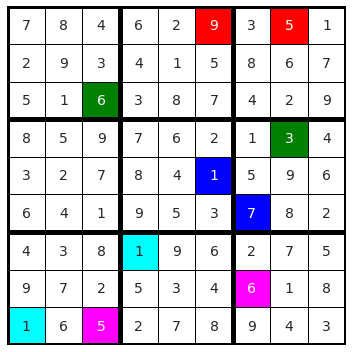

In [46]:
N = 9
M = int(np.max(nodes))

s = Tactic("pqffd").solver()

X = np.array(IntVector('x', N*N),dtype=object).reshape((N,N))

#standard rules
s += [And(e>0,e<10) for (i,j),e in np.ndenumerate(X)]
s += [Distinct([e for (i,j),e in np.ndenumerate(X) if i == n]) for n in range(N)]
s += [Distinct([e for (i,j),e in np.ndenumerate(X) if j == n]) for n in range(N)]

groups = np.block([[np.ones((3,3),dtype=int)*(i+j*3) for i in range(3)]for j in range(3)])
s += [Distinct([e for (i,j),e in np.ndenumerate(X) if groups[i,j] == n]) for n in range(N)]

s += And([e == int(fix[i,j]) for (i,j),e in np.ndenumerate(X) if fix[i,j] != 0])  

edge = {}
for i in range(N):
    for j in range(N):  
        for (k,l) in neigh(i,j,N) :
            edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))

s += [And(e>=0,e<=M) for _,e in edge.items()]

for i in range(N):
    for j in range(N):  
        for (k,l) in neigh(i,j,N):
            # Make edges one way to form a tree
            s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1
            # Cells with an edge have the same value
            s +=Implies(edge[(k,l,i,j)] == 1,X[i,j] == X[k,l])



start = time.time()
evalu = np.vectorize(lambda x :m.evaluate(x).as_long())
if s.check() == sat:
    print("Took {} secs".format(time.time()-start))
    m = s.model()
    result = evalu(X)
    edge_result = {(i,j,k,l):evalu(e) for (i,j,k,l),e in edge.items()}
    sol_print(result,edge_result,nodes)
else:
    print("Failed in {} seconds".format(time.time()-start))



In [40]:
edge_result

{(0, 0, 1, 0): array(0),
 (0, 0, 0, 1): array(0),
 (0, 1, 0, 0): array(0),
 (0, 1, 1, 1): array(0),
 (0, 1, 0, 2): array(0),
 (0, 2, 0, 1): array(0),
 (0, 2, 1, 2): array(0),
 (0, 2, 0, 3): array(0),
 (0, 3, 0, 2): array(0),
 (0, 3, 1, 3): array(0),
 (0, 3, 0, 4): array(0),
 (0, 4, 0, 3): array(0),
 (0, 4, 1, 4): array(0),
 (0, 4, 0, 5): array(0),
 (0, 5, 0, 4): array(0),
 (0, 5, 1, 5): array(0),
 (0, 5, 0, 6): array(0),
 (0, 6, 0, 5): array(0),
 (0, 6, 1, 6): array(0),
 (0, 6, 0, 7): array(0),
 (0, 7, 0, 6): array(0),
 (0, 7, 1, 7): array(0),
 (0, 7, 0, 8): array(0),
 (0, 8, 0, 7): array(0),
 (0, 8, 1, 8): array(0),
 (1, 0, 0, 0): array(0),
 (1, 0, 2, 0): array(0),
 (1, 0, 1, 1): array(0),
 (1, 1, 0, 1): array(0),
 (1, 1, 1, 0): array(0),
 (1, 1, 2, 1): array(0),
 (1, 1, 1, 2): array(0),
 (1, 2, 0, 2): array(0),
 (1, 2, 1, 1): array(0),
 (1, 2, 2, 2): array(0),
 (1, 2, 1, 3): array(0),
 (1, 3, 0, 3): array(0),
 (1, 3, 1, 2): array(0),
 (1, 3, 2, 3): array(0),
 (1, 3, 1, 4): array(0),
